In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime


In [2]:
def get_token_decimals(asset_symbol):
    """Get decimal places for common tokens"""
    symbol = asset_symbol.upper()
    if symbol in ['USDC', 'USDT']:
        return 6
    elif symbol == 'WBTC':
        return 8
    else:  # Default to 18 decimals (ETH, MATIC, DAI, etc.)
        return 18

def load_and_preprocess(file_path):
    """Load JSON data and preprocess transaction amounts"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    processed = []
    for tx in data:
        try:
            # Extract main fields
            user = tx['userWallet']
            action = tx['action']
            amount_str = tx['actionData']['amount']
            asset_symbol = tx['actionData']['assetSymbol']
            asset_price = float(tx['actionData']['assetPriceUSD'])
            timestamp = tx['timestamp']
            
            # Skip if not a recognized action
            if action not in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
                continue
                
            # Convert amount to proper USD value
            decimals = get_token_decimals(asset_symbol)
            amount_base = float(amount_str)
            amount_token = amount_base / (10 ** decimals)
            amount_usd = amount_token * asset_price
            
            processed.append({
                'user': user,
                'action': action,
                'amount_usd': amount_usd,
                'timestamp': timestamp
            })
        except (KeyError, TypeError, ValueError) as e:
            print(f"Skipping invalid transaction: {e}")
    
    return pd.DataFrame(processed)


In [6]:
def engineer_features(df):
    """Create features from transaction data"""
    # Convert timestamp and sort
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.sort_values(['user', 'datetime'])
    
    # Group by wallet
    grouped = df.groupby('user')
    
    # Initialize features dataframe
    features = pd.DataFrame(index=grouped.groups.keys())
    features.index.name = 'user'
    
    # 1. Transaction counts and frequencies
    features['txn_count'] = grouped.size()
    features['active_days'] = (grouped['datetime'].max() - grouped['datetime'].min()).dt.days
    features['active_days'] = features['active_days'].fillna(0).replace(0, 1)  # Handle single-transaction users
    features['txn_freq'] = features['txn_count'] / features['active_days']
    
    # 2. Action type ratios
    action_types = ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']
    for action in action_types:
        features[f'{action}_count'] = grouped['action'].apply(lambda x: (x == action).sum())
        features[f'{action}_ratio'] = features[f'{action}_count'] / features['txn_count']
    
    # 3. Repayment health metrics
    def calculate_repayment(group):
        borrowed = group[group['action'] == 'borrow']['amount_usd'].sum()
        repaid = group[group['action'] == 'repay']['amount_usd'].sum()
        return repaid / borrowed if borrowed > 0 else 1.0
    
    features['repayment_ratio'] = grouped.apply(calculate_repayment)
    features['borrow_deposit_ratio'] = features['borrow_count'] / (features['deposit_count'] + 0.001)
    
    # 4. Liquidation events
    features['liquidation_events'] = features['liquidationcall_count']
    
    # 5. Transaction pattern analysis
    def time_analysis(group):
        if len(group) < 2:
            return 0, 0
        time_diffs = group['datetime'].diff().dt.total_seconds().dropna()
        return time_diffs.mean(), time_diffs.std()
    
    features[['time_mean', 'time_std']] = grouped.apply(time_analysis).apply(pd.Series)
    
    return features.reset_index()

def generate_credit_scores(features):
    """Generate credit scores using Isolation Forest"""
    # Select relevant features
    feature_cols = [
        'txn_freq',
        'deposit_ratio', 
        'borrow_ratio',
        'repay_ratio',
        'redeemunderlying_ratio',
        'liquidationcall_ratio',
        'repayment_ratio',
        'borrow_deposit_ratio',
        'time_std'
    ]
    
    # Prepare data
    X = features[feature_cols].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train model
    model = IsolationForest(
        n_estimators=500,
        contamination=0.1,
        random_state=42,
        verbose=0
    )
    model.fit(X_scaled)
    
    # Convert anomaly scores to credit scores (0-1000)
    anomaly_scores = model.score_samples(X_scaled)
    credit_scores = 1000 * (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    features['credit_score'] = np.clip(credit_scores, 0, 1000).round().astype(int)
    
    # Apply business rules
    # Rule 1: Any liquidation event caps score at 300
    features.loc[features['liquidation_events'] > 0, 'credit_score'] = 300
    
    # Rule 2: Low repayment ratio penalty
    repayment_mask = features['repayment_ratio'] < 0.5
    features.loc[repayment_mask, 'credit_score'] = (features.loc[repayment_mask, 'credit_score'] * 0.5).astype(int)
    
    # Rule 3: High borrow/deposit ratio penalty
    leverage_mask = features['borrow_deposit_ratio'] > 3
    features.loc[leverage_mask, 'credit_score'] = (features.loc[leverage_mask, 'credit_score'] * 0.7).astype(int)
    
    return features[['user', 'credit_score']]

def main(input_file, output_file):
    """End-to-end scoring pipeline"""
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = load_and_preprocess(input_file)
    
    if df.empty:
        print("No valid transactions found")
        return
    
    # Engineer features
    print("Engineering features...")
    features = engineer_features(df)
    
    # Generate credit scores
    print("Generating credit scores...")
    scores = generate_credit_scores(features)
    
    # Save results
    scores.to_json(output_file, orient='records', indent=2)
    print(f"Saved credit scores to {output_file}")

if __name__ == "__main__":
    input_file = "user-wallet-transactions.json"
    output_file = "wallet_credit_scores.json"
    main(input_file, output_file)

Loading and preprocessing data...
Engineering features...


C:\Users\harshvardhan\AppData\Local\Temp\ipykernel_8168\825630476.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features['repayment_ratio'] = grouped.apply(calculate_repayment)
C:\Users\harshvardhan\AppData\Local\Temp\ipykernel_8168\825630476.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features[['time_mean', 'time_std']] = grouped.apply(time_analysis).apply(pd.Series)


Generating credit scores...
Saved credit scores to wallet_credit_scores.json


In [9]:
# Load and preprocess data
input_file = "user-wallet-transactions.json"  # Update path if needed
df = load_and_preprocess(input_file)

# Engineer features
features_df = engineer_features(df)

# Generate credit scores
scores_df = generate_credit_scores(features_df)

# Display results
print(scores_df.head())

# Save to JSON
scores_df.to_json("wallet_credit_scores.json", orient='records', indent=2)

C:\Users\harshvardhan\AppData\Local\Temp\ipykernel_8168\825630476.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features['repayment_ratio'] = grouped.apply(calculate_repayment)
C:\Users\harshvardhan\AppData\Local\Temp\ipykernel_8168\825630476.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features[['time_mean', 'time_std']] = grouped.apply(time_analysis).apply(pd.Series)


                                         user  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6          1000
1  0x000000000051d07a4fb3bd10121a343d85818da6          1000
2  0x000000000096026fb41fc39f9875d164bd82e2dc           941
3  0x0000000000e189dd664b9ab08a33c4839953852c           416
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee           644


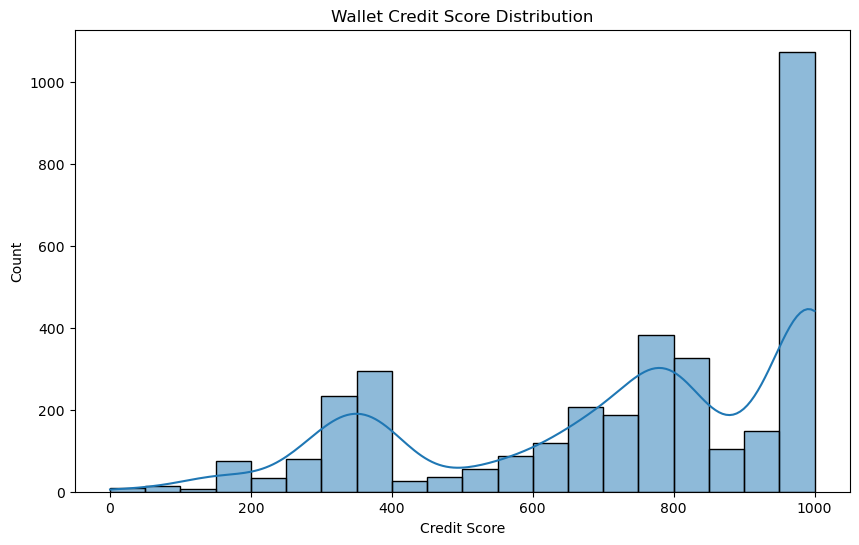

Top 10 Wallets:


,user,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1000
701,0x012186399add91fcdc4504bcd9c44a2169d4b32c,1000
2868,0x04f6bf8745b567f40cc01a330f128b6a4924ee49,1000
2867,0x04f697d98ce1f8474e39080cd83f5f6c0c1c3566,1000
1356,0x0245f104b40838219ccb47ca912b957848072e5b,1000
709,0x01253d735f350afc426335560251171367cd095d,1000
1355,0x0245126a00cc1d2030adc172e8940daac4cbaf18,1000
711,0x012668a6f1b462d55bb77bdd4dec5c8e57463e43,1000
712,0x01270d19f1b70c3f24efb57d28974b3d664dd7e6,1000
1354,0x02447847989945cf88041ee712d9cd8dcc8ecc36,1000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot score distribution
plt.figure(figsize=(10, 6))
sns.histplot(scores_df['credit_score'], bins=20, kde=True)
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

# Top 10 wallets
print("Top 10 Wallets:")
scores_df.sort_values('credit_score', ascending=False).head(10)

In [11]:
# Save to JSON file
scores_df.to_json("wallet_credit_scores.json", orient='records', indent=2)

# Save to CSV
scores_df.to_csv("wallet_credit_scores.csv", index=False)